# RAG: ROUTING

** Courtesy - https://github.com/langchain-ai/ (lance Martin)



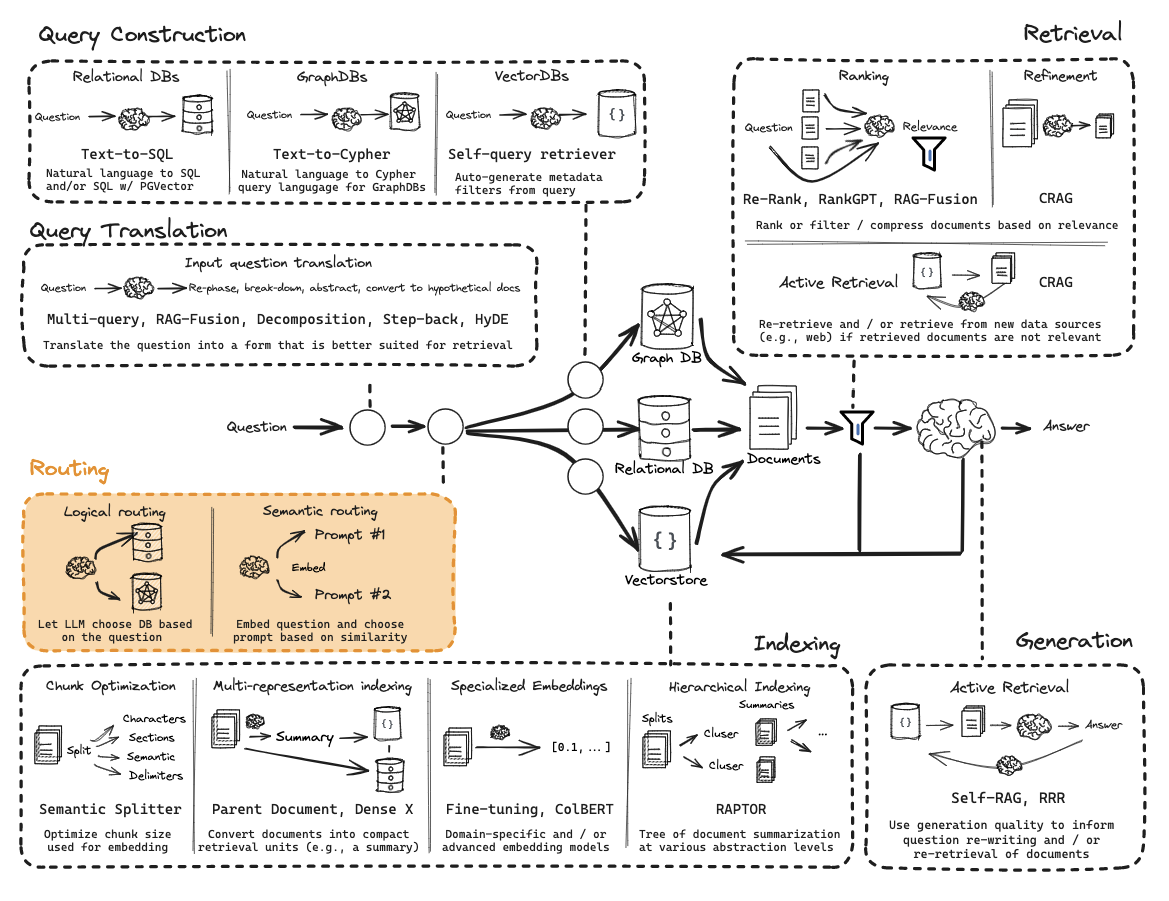

In [4]:
!pip install beautifulsoup4 langchain langchain_community langchain_core langchain_groq langchain_text_splitters

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully

In [6]:
import os
import bs4
import time
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain.load import dumps, loads
from typing import Literal
from pprint import pprint

In [12]:
from langchain_core.runnables import RunnableLambda

I used the google colab to create this pipeline. so its recommended to use colab secrets to store the credentials.

we would be required to create account at

```Pinecone
Groq
Langsmith
openai
```
you have to copy the api keys of all the above account to the secrets. the api keys can be fetched using


```

from google.colab import userdata
secret = userdata.get('secret-key')
make sure to have api keys ready.
```

In [2]:
from google.colab import userdata
groq_key = userdata.get('groq-key')
smith_key = userdata.get('smith-key')
pine_key = userdata.get('pine-key')
openai_key = userdata.get('openai-key')

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_PROJECT'] = 'rag-query-routing'
os.environ['LANGCHAIN_API_KEY'] = smith_key
os.environ['GROQ_API_KEY'] = groq_key

**This excercise will help in understanding: How to route the query to the relevant data source.**





https://python.langchain.com/docs/use_cases/query_analysis/techniques/routing#routing-to-multiple-indexes

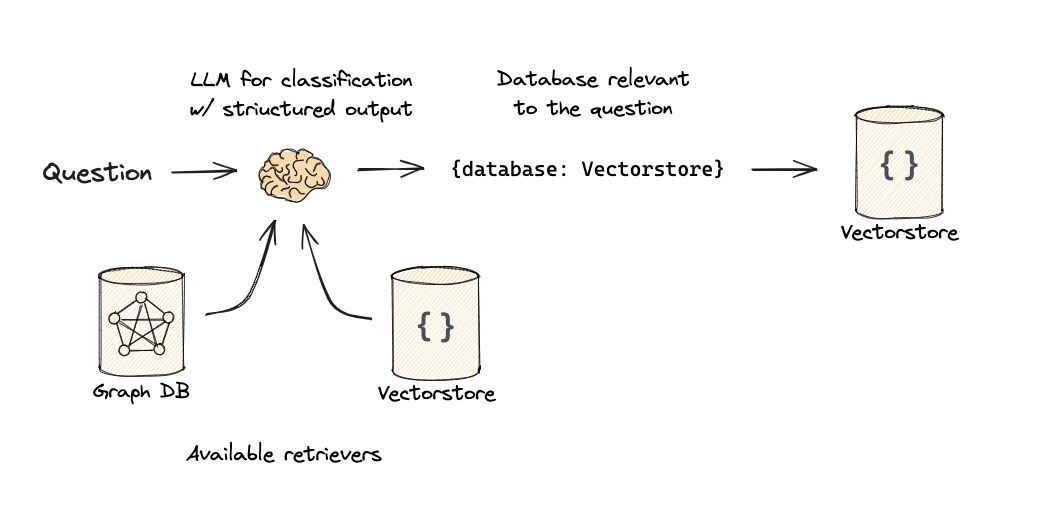

In [7]:
class RouteQuery(BaseModel):
  """Route to the relevant document based on your query"""

  data_source: Literal["tf_docs", "pytorch_docs"] = Field(
      ...,
      description = "Given a user question choose which datasource would be most relevant for answering their question"
  )

In [8]:
llm = ChatGroq(temperature=0)

structured_llm = llm.with_structured_output(
    schema=RouteQuery
  )

In [9]:
# prompt


system = """You are an expert at routing a user question to the appropriate data source.

Based on the programming language the question is referring to, route it to the relevant data source."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

router = prompt | structured_llm

print(router)

first=ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are an expert at routing a user question to the appropriate data source.\n\nBased on the programming language the question is referring to, route it to the relevant data source.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='{question}'), additional_kwargs={})]) middle=[RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7a11a19d6e90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7a11a19d61d0>, temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'RouteQuery', 'description': 'Route to the relevant document ba

In [10]:
question = """Why doesn't the following code work:

class Custom_transformer(nn.module)

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")
"""

result = router.invoke({"question": question})

In [11]:
result

RouteQuery(data_source='pytorch_docs')

In [23]:
def call_document(result):
  match result.data_source:
      case "pytorch_docs": return "https://pytorch.org/docs/stable/index.html"
      case "tf_docs": return "https://www.tensorflow.org/api_docs"
      case _: return "not in data source"


In [24]:
updated_chain = router | RunnableLambda(call_document)

In [25]:
updated_chain.invoke({"question": question})

'https://pytorch.org/docs/stable/index.html'

# Semantic Routing

**You can also route your query based on the semantics: the more closer it associates with the datasource, that data source becomes the source for next course of action**

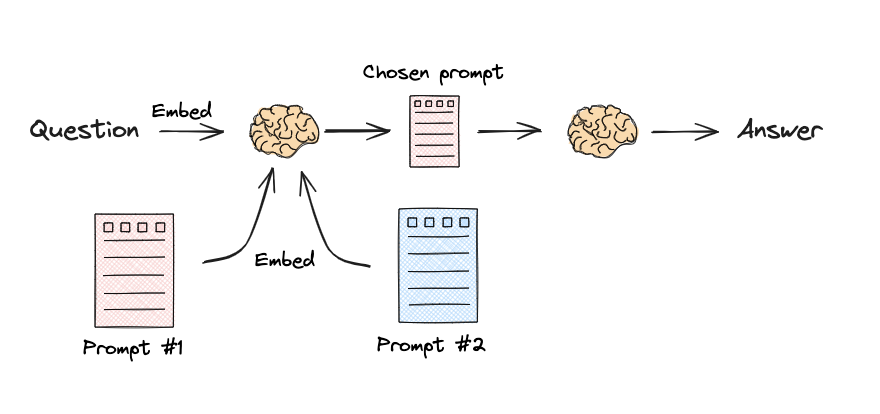

In [27]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 4.9 MB/s eta 0:00:00


In [28]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

# Two prompts
pytorch_template = """You are a very smart pytorch coder. \
You are great at debugging questions about pytorch in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

tf_template = """You are a very good tensorflow coder. You are great at solving tensorflow questions. \
You are so good because you are able to debug hard problems by decomposing into sub problems, \
answer the sub problem parts, and then put them together to answer the broader question.

Here is a question:
{query}"""

# Embed prompts
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)
prompt_templates = [pytorch_template, tf_template]
prompt_embeddings = hf_embeddings.embed_documents(prompt_templates)

# Route question to prompt
def prompt_router(input):
    # Embed question
    query_embedding = hf_embeddings.embed_query(input["query"])
    # Compute similarity
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    # Chosen prompt
    print("solving pytorch" if most_similar == pytorch_template else "solving tensorflow")
    return PromptTemplate.from_template(most_similar)


chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | ChatGroq()
    | StrOutputParser()
)

print(chain.invoke("What is the backward calculation step code in pytorch"))

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

solving pytorch
In PyTorch, the backward calculation step can be performed using the `backward()` function. This function computes the gradient of a given tensor with respect to the variables that it depends on. Here's an example:
```python
import torch

# define some tensors
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
z = x**2 + y**3

# compute the loss
loss = z**2

# perform backpropagation and compute gradients
loss.backward()

# print gradients
print(x.grad)  # outputs tensor(-12.)
print(y.grad)  # outputs tensor(27.)
```
In this example, we define three tensors `x`, `y`, and `z`, where `z` is a function of `x` and `y`. We then define a loss function that takes `z` as its input. By calling `loss.backward()`, we compute the gradients of the loss with respect to `x` and `y`. These gradients are stored in the `grad` attribute of the corresponding tensors.

Note that the `backward()` function accumulates gradients by default. This means that if y